# Exercise 3

## Task 1
Consider the 1D unsteady diffusion equation in cartesian coordinates:
\begin{align}
\frac{\partial C}{\partial t} = D \frac{\partial^2 C_i}{\partial t^2} \ ,
\end{align}

with D = 10−6 the binary diffusion coefficient. The size of the domain along x is h
(i.e. the domain is characterized by a finite length). The grid spacing is ∆x (obtained
discretizing the domain length h using Nx points), and the time step is ∆t. Initial
condition is C = 0 everywhere inside the domain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

# 1.) Explicit scheme: Inhom. Dirichlet at x=0/ hom. Neumann at x=h
Assume Dirichlet/Neumann boundary conditions: C = 1 at x = 0 and ∂C/∂x =
0 at x = h. Solve Eq. 1 by an explicit finite difference approach that is 2nd order accurate in space and 1st order accurate in time. Compare the results with
the analytical solution (see Lecture for reference). Show that the numerical solution is not unconditionally stable. In particular, show that it is unstable for
d = D∆t/∆x2 > 0.5. [2 POINTS]

In [2]:
from enum import Enum
from math import sqrt

class BType(Enum):
    # Doesn't work :/
    DIRICHLET = 0
    NEUMANN = 1
    ROBIN = 2

class BC:
    def __init__(self, btype:int=0, value=0):
        self.btype = btype
        self.v = value

    def __repr__(self):
        return f"BC({self.btype}, val={self.v})"

class Boundary:
    def __init__(self, BC1:BC=BC(), BC2:BC=BC()):
        self.left = BC1
        self.right = BC2

    def __repr__(self):
        return f"Boundary(left: {self.left}, right: {self.right})" 

    def __iter__(self):
        return iter([self.left, self.right])

class Domain:
    def __init__(self, h:float=1, Nx:int=251, dt:float=8e-6, bd=Boundary()):
        """Init a domain

        defaults will init a domain like in slides for lecture 7, p41
        """
        self.h = h
        self.Nx = Nx
        self.dx = h/(Nx-1)
        self.dt = dt
        self.s = dt/(self.dx*self.dx)
        if self.s > 0.5:
            response = input(f"Simulation unstable: s={self.s} - Autostabilize? (y/n): ")
            if response == 'y' or response == 'Y':
                self.stabilize()
        self.boundaries = bd

    def __repr__(self):
        return f"Domain(h={self.h:.2f}, Nx={self.Nx:d}, dt={self.dt:.2e}, (dx={self.dx:.2e}, s={self.s:.2e}), Boundaries: {self.boundaries})"

    def stabilize(self, target:float=0.4):
        self.Nx = int(round(1 + self.h * sqrt(target/self.dt), 0))
        self.dx = self.h/(self.Nx-1)
        self.s = target
        print(f"New: (Nx={self.Nx}, dx={self.dx}, s={self.s})")


# A Test
testdomain = Domain()
print(testdomain)
del testdomain

bc = BC("Dir", 2)
print(bc)
bound = Boundary()
print(bound)
for bd in bound:
    print(bd)

Domain(h=1.00, Nx=251, dt=8.00e-06, (dx=4.00e-03, s=5.00e-01), Boundaries: Boundary(left: BC(0, val=0), right: BC(0, val=0)))
BC(Dir, val=2)
Boundary(left: BC(0, val=0), right: BC(0, val=0))
BC(0, val=0)
BC(0, val=0)


In [99]:
class ExplicitSolver():
    def __init__(self, domain:Domain):
        """Init a solver for a domain.
        """
        print("Solver with s=", domain.s)
        self.domain = domain
        self.A = np.zeros((domain.Nx, domain.Nx), dtype=np.float64)
        self.rhs = np.zeros(domain.Nx, dtype=np.float64)
        self.sol = np.zeros_like(self.rhs)
        self.initMatrix(domain)
        self.initRhs(domain)
        self.initSol(domain)

    def initMatrix(self, domain:Domain):
        """Calculate iteration matrix based on domain

        args:
        domain... domain to initialize solver for, should be of type Domain
        """
        print(domain.Nx)
        s = domain.s
        maindiag = (1 - 2*s) * np.ones(domain.Nx)
        offdiags = s * np.ones(domain.Nx-1)
        # Check boundary conditions
        # i index of the diagonal arrays... 0=left, -1=right
        for i, boundary in zip([0, 1], domain.boundaries):
            if boundary.btype == 0: # Dirichlet
                # --> dont update
                maindiag[-i], offdiags[-i] = (1, 0)
            if boundary.btype == 1: # Neumman
                # --> dont update
                maindiag[-i] = s
                self.A[-i,-i-1] = -s + (1-2*s)
                self.A[-i,-i-2] = s
        # Construct matrix
        self.A += np.diag(maindiag, k=0) + np.diag(offdiags, k=1) + np.diag(offdiags[::-1], k=-1)
        #for i, boundary in zip([0, 1], domain.boundaries):
         #   if boundary.btype == 1: # Neumann
          #      self.A[-i,-i-1] = -s + (1-2*s)
           #     self.A[-i,-i-2] = s

    def printMatrix(self, n:int=4):
        """Print head and tail submatrices of size nxn.

        args:
        n... gives size of submatrices, integer, default=4
        """
        print("Head:")
        print(self.A[:n,:n])
        print("...")
        print("Tail:")
        print(self.A[-n:,-n:])

    def plot(self, iterations):
        h, N = (self.domain.h, self.domain.Nx)
        plt.suptitle(f"Concentration after {iterations} iterations")
        plt.plot(np.linspace(0, h, N), self.sol, label="it: "+str(iterations))

    def initRhs(self, domain:Domain):
        pass

    def initSol(self, domain:Domain):
        for i, boundary in zip([0, -1], domain.boundaries):
            self.sol[i] = boundary.v

    def iterate(self, iterations=100, saveEvery=0):
        if saveEvery:
            plt.figure(figsize=(10,8))
            plt.xlabel("x")
            plt.ylabel("C(x)")
            plt.grid()
        for i in range(1,1+iterations):
            if saveEvery:
                if i%saveEvery == 0:
                    self.plot(i)
                    #storage.append(np.sol) 
            self.sol = np.dot(self.A, self.sol)
        plt.legend()

In [100]:
if 0: print("Hi")

In [101]:
print(BType.DIRICHLET)
print(BType.NEUMANN)
for t in BType:
    print(t)

BType.DIRICHLET
BType.NEUMANN
BType.DIRICHLET
BType.NEUMANN
BType.ROBIN


Using domain: Domain(h=1.00, Nx=633, dt=1.00e-06, (dx=1.58e-03, s=3.99e-01), Boundaries: Boundary(left: BC(0, val=1), right: BC(1, val=0)))
Solver with s= 0.399424
633
Head:
[[1.       0.       0.       0.      ]
 [0.399424 0.201152 0.399424 0.      ]
 [0.       0.399424 0.201152 0.399424]
 [0.       0.       0.399424 0.201152]]
...
Tail:
[[ 0.201152  0.399424  0.        0.      ]
 [ 0.399424  0.201152  0.399424  0.      ]
 [ 0.        0.399424  0.201152  0.399424]
 [ 0.        0.399424 -0.198272  0.399424]]
Final solution:
[1.00000000e+00 9.93687790e-01 9.87375975e-01 9.81064950e-01
 9.74755110e-01 9.68446849e-01 9.62140562e-01 9.55836642e-01
 9.49535484e-01 9.43237480e-01 9.36943023e-01 9.30652504e-01
 9.24366313e-01 9.18084843e-01 9.11808481e-01 9.05537616e-01
 8.99272635e-01 8.93013925e-01 8.86761870e-01 8.80516855e-01
 8.74279262e-01 8.68049471e-01 8.61827863e-01 8.55614816e-01
 8.49410705e-01 8.43215907e-01 8.37030794e-01 8.30855738e-01
 8.24691107e-01 8.18537270e-01 8.12394592e-

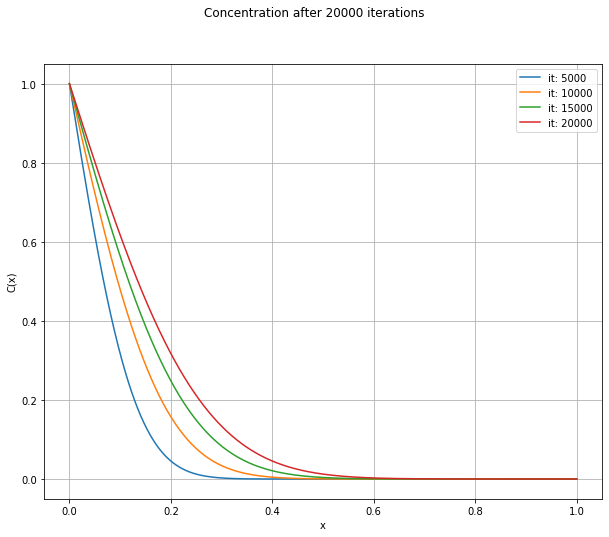

In [102]:
# Please choose some parameters:
N = 633
dt = 1e-6
# If the simulation is not stable (s=dt/dx² > 0.5), then you will prompted to accept or decline the autostabilization.
#   - Autostabilization uses the user requested dt, sets s=0.4 and calculates the appropiate (Nx, dx).

# Settings up boundaries and the domain
left = BC(0, 1) # inhom Dirichlet BC with C=1
right = BC(1, 0) # hom Neumann BC
bd1 = Boundary(BC1=left, BC2=right)
domain1 = Domain(Nx=N, dt=dt, bd=bd1)


print("Using domain:", domain1)
solver = ExplicitSolver(domain1)
solver.printMatrix()
response = input("Start simulation? (y/n): ")
yes = any(response==y for y in ['y', 'Y']) 
#yes = (response == 'y' or response == 'Y')
if yes:
    mult = 5000
    total_iterations = 20000
    solver.iterate(iterations=total_iterations, saveEvery=mult)


    print("Final solution:")
    print(solver.sol)
else:
    print("User aborted.")

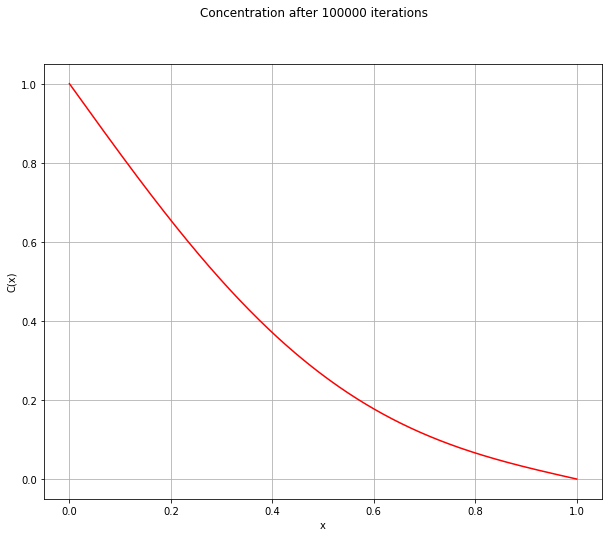

In [66]:
h, N = (domain1.h, domain1.Nx)

plt.figure(figsize=(10,8))
plt.suptitle(f"Concentration after {total_iterations} iterations")
plt.plot(np.linspace(0, h, N), solver.sol, 'r-', label="C(x)")
plt.xlabel("x")
plt.ylabel("C(x)")
plt.grid()

# 2.) Explicit scheme: Inhom. Dirichlet at x=0/ hom. Dirichlet at x=h
Assume Dirichlet boundary conditions at both boundaries: C = 1 at x = 0 and
C = 0 at x = h. Solve Eq. 1 for the same cases and using the same discretization
strategy (i.e. explicit finite difference approach, 2nd order in space and 1st order
in time) analyzed at point 1. Compare the long term behavior, limt→∞ C(x), of
the present case with that of the previous case, point 1. [2 POINTS]

# 3.) Implicit scheme (2.Order space/1.Order time): Inhom. Dirichlet at x=0/ hom. Neumann at x=h
Assume Dirichlet/Neumann boundary conditions: i.e. C = 1 at x = 0 and
∂C/∂x = 0 at x = h. Solve the equation using an implicit scheme (2nd order
in space and 1st order in time) and discuss the stability of the solution. Compare
the new results with those obtained at point 1. [2 POINTS]

# 4.) Implicit scheme (2.Order space/2.Order time): Inhom. Dirichlet at x=0/ hom. Neumann at x=h
Assume Dirichlet/Neumann boundary conditions: i.e. C = 1 at x = 0 and
∂C/∂x = 0 at x = h. Solve the equation using an implicit scheme that is 2nd
order in space and 2nd order in time. Discuss the accuracy of the solution in
comparison with that obtained at point 3. [2 POINTS]
Produce plots and movies to support your conclusions (for your convenience, you can
take plots and movies presented during the lecture as reference for the purpose)